In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import statsmodels.api as sm

# Need to move TRANSFORMERS and text_to_code_q6 to other script
from build_model_multinomial import TRANSFORMERS, text_to_code_q6, text_to_code_q10_2_binary, fallback_text_to_float
from build_model_logistic import build_v2g_model_binary_from_df, run_single_feature_regressions, filter_significant_features
from get_data import init_column_map, pull_data_rowwise

from logistic_results_plot import (
    plot_feature_significance, 
    plot_coefficients_barh_by_abscoef, 
    plot_odds_ratio_barh, 
    plot_p_value_barh, 
    plot_log_p_value_barh, 
    plot_coefficients_significance_barh, 
    plot_coefficient_vs_significance,
    plot_coefficients_barplot,
    plot_odds_ratios_barplot,
    plot_coefficients_by_abs,
    plot_binary_confusion_matrix,
    transform_and_plot_correlation
)

from segmentation import filter_data

In [2]:
# Define all variable categories
from variables import (
    demographics, 
    input_variables_vehicle_ownership, 
    familiarity, 
    kms_driven, 
    renewables_at_home,
    parking, 
    q6a_cols, 
    energ_literacy, 
    renewables_at_home, 
    intent_to_purchase_vehicle,
    benefits_v2g, 
    concerns_v2g, 
    interest_in_services, 
    consider_using_NRMA_for,
    charging_control, 
    preference_on_batt_use, 
    expected_return,
    q6a_petrol, q6a_ev, q6a_plughyb, q6a_hybrid,
#     charging_control,
    feature_label_map
)

# 2. Model Setup

## 2.1. Initialise dataframe

In [3]:
csv_file = './data/survey_pre_processed_data.csv'

In [4]:
target_variable = 'Q10_2'  # "I would be interested in installing V2G..."

In [5]:
q10_2_categories = [
    "Strongly disagree",
    "Somewhat disagree",
    "Neither agree nor disagree",
    "Somewhat agree",
    "Strongly agree"
    ]

In [6]:
# Pull the data from CSV
init_column_map(csv_file)

# TBD -> Make function here
columns_of_interest = (
    familiarity +
    kms_driven + 
    renewables_at_home + 
    q6a_cols + 
    demographics + 
    input_variables_vehicle_ownership + 
    parking + 
    benefits_v2g + 
    concerns_v2g +
    energ_literacy +
#   charging_control +
    [target_variable]
    )

rows = pull_data_rowwise(columns_of_interest, csv_file)

# Make a DataFrame
df = pd.DataFrame(rows, columns=columns_of_interest)
df

,Q9,Q2,Q8_1,Q8_2,Q8_99,Q6ax1_1,Q6ax1_2,Q6ax1_3,Q6ax2_1,Q6ax2_2,...,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_99,Q7_1,Q7_2,Q7_3,Q10_2
0,Somewhat familiar,"Less than 10,000",1,0,0,3,5,5,,,...,1,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,Neither agree nor disagree
1,Very familiar,"Less than 10,000",1,1,0,5,5,5,5,5,...,0,0,0,0,0,1,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
2,Not at all familiar,"20,001-50,000",0,0,1,2,1,2,,,...,0,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,Strongly disagree
3,Not at all familiar,"Less than 10,000",0,0,1,,,,,,...,0,0,0,0,0,0,Somewhat disagree,Somewhat disagree,Somewhat agree,Somewhat disagree
4,Very familiar,"20,001-50,000",1,1,0,5,5,5,4,4,...,0,1,0,0,0,0,Strongly agree,Strongly agree,Somewhat agree,Somewhat agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,Somewhat familiar,"10,000-20,000",1,1,0,,,,1,3,...,1,1,0,0,0,0,Strongly agree,Strongly agree,Neither agree nor disagree,Strongly agree
1354,Somewhat familiar,"Less than 10,000",0,0,1,5,5,5,,,...,0,0,1,0,1,0,Strongly agree,Somewhat agree,Somewhat agree,Neither agree nor disagree
1355,Very familiar,"10,000-20,000",1,0,0,4,4,5,4,4,...,0,1,0,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,Strongly agree
1356,Very familiar,"10,000-20,000",0,0,1,,,,3,5,...,0,0,0,0,1,0,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,Somewhat agree


## 2.2. Segment

In [7]:
'''

Here's the only thing different from previous notebook.
We'll consider a segmentation based on a question (or combination of)

e.g.:
segment_1_filters = ["Q1_2 == '1'", "(Q3_1 == '1') | (Q3_2 == '1')"]
or
filters = ["Q1_2 == '1'"]

'''

'\n\nHere\'s the only thing different from previous notebook.\nWe\'ll consider a segmentation based on a question (or combination of)\n\ne.g.:\nsegment_1_filters = ["Q1_2 == \'1\'", "(Q3_1 == \'1\') | (Q3_2 == \'1\')"]\nor\nfilters = ["Q1_2 == \'1\'"]\n\n'

In [8]:
#df[input_variables_vehicle_ownership] = df[input_variables_vehicle_ownership].apply(pd.to_numeric, errors='coerce')
#df[renewables_at_home] = df[renewables_at_home].apply(pd.to_numeric, errors='coerce')

In [9]:
filters = [
    "(Q1_2 == '1') & "
    "((Q22 == 'Own outright') | (Q22 == 'Own with mortgage')) & "
    "((Q21 == 'Townhouse') | (Q21 == 'Freestanding house') | (Q21 == 'Semidetached or terrace')) & "
    "(Q8_1 == '1')"
]

In [10]:
# EV owners
df = filter_data(df, filters)

In [11]:
df

,Q9,Q2,Q8_1,Q8_2,Q8_99,Q6ax1_1,Q6ax1_2,Q6ax1_3,Q6ax2_1,Q6ax2_2,...,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_99,Q7_1,Q7_2,Q7_3,Q10_2
1,Very familiar,"Less than 10,000",1,1,0,5,5,5,5,5,...,0,0,0,0,0,1,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
4,Very familiar,"20,001-50,000",1,1,0,5,5,5,4,4,...,0,1,0,0,0,0,Strongly agree,Strongly agree,Somewhat agree,Somewhat agree
5,Very familiar,"20,001-50,000",1,0,0,5,5,5,5,5,...,0,0,1,0,0,0,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
10,Somewhat familiar,"10,000-20,000",1,0,0,2,2,5,1,3,...,1,1,0,0,0,0,Strongly agree,Strongly agree,Somewhat agree,Neither agree nor disagree
11,Very familiar,"10,000-20,000",1,1,0,,,,3,4,...,1,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,Somewhat familiar,"10,000-20,000",1,1,0,,,,3,5,...,0,1,1,0,0,0,Strongly agree,Somewhat agree,Somewhat disagree,Strongly agree
1352,Very familiar,"10,000-20,000",1,0,0,,,,2,3,...,0,1,0,0,1,0,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
1353,Somewhat familiar,"10,000-20,000",1,1,0,,,,1,3,...,1,1,0,0,0,0,Strongly agree,Strongly agree,Neither agree nor disagree,Strongly agree
1355,Very familiar,"10,000-20,000",1,0,0,4,4,5,4,4,...,0,1,0,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,Strongly agree


## 2.2. Clean data

In [12]:
# Ensure "0 - Weekdays" is converted correctly
for col in q6a_cols:
    df[col] = df[col].replace("0 - Weekdays", 0)  # Convert "0 - Weekdays" to 0
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert all values to numbers

# Debugging: Check unique values in each column
for col in q6a_cols:
    print(f"Unique values in {col}: {df[col].dropna().unique()}")

Unique values in Q6ax1_1: [5. 2. 0. 3. 4. 1.]
Unique values in Q6ax1_2: [5. 2. 4. 3. 0. 1.]
Unique values in Q6ax1_3: [5. 4. 0. 3. 1.]
Unique values in Q6ax2_1: [5 4 1 3 2 0]
Unique values in Q6ax2_2: [5 4 3 2 0 1]
Unique values in Q6ax2_3: [5 4 3 1 0 2]
Unique values in Q6ax3_1: [3. 1. 2. 4. 5.]
Unique values in Q6ax3_2: [5.]
Unique values in Q6ax3_3: [5.]
Unique values in Q6ax4_1: [2. 0. 5. 4. 3. 1.]
Unique values in Q6ax4_2: [2. 0. 4. 5. 3. 1.]
Unique values in Q6ax4_3: [5. 0. 1. 4.]


C:\Users\24417507\AppData\Local\Temp\ipykernel_9356\3713354050.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].replace("0 - Weekdays", 0)  # Convert "0 - Weekdays" to 0
C:\Users\24417507\AppData\Local\Temp\ipykernel_9356\3713354050.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert all values to numbers


In [13]:
df

,Q9,Q2,Q8_1,Q8_2,Q8_99,Q6ax1_1,Q6ax1_2,Q6ax1_3,Q6ax2_1,Q6ax2_2,...,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_99,Q7_1,Q7_2,Q7_3,Q10_2
1,Very familiar,"Less than 10,000",1,1,0,5.0,5.0,5.0,5,5,...,0,0,0,0,0,1,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
4,Very familiar,"20,001-50,000",1,1,0,5.0,5.0,5.0,4,4,...,0,1,0,0,0,0,Strongly agree,Strongly agree,Somewhat agree,Somewhat agree
5,Very familiar,"20,001-50,000",1,0,0,5.0,5.0,5.0,5,5,...,0,0,1,0,0,0,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
10,Somewhat familiar,"10,000-20,000",1,0,0,2.0,2.0,5.0,1,3,...,1,1,0,0,0,0,Strongly agree,Strongly agree,Somewhat agree,Neither agree nor disagree
11,Very familiar,"10,000-20,000",1,1,0,NaN,NaN,NaN,3,4,...,1,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,Somewhat familiar,"10,000-20,000",1,1,0,NaN,NaN,NaN,3,5,...,0,1,1,0,0,0,Strongly agree,Somewhat agree,Somewhat disagree,Strongly agree
1352,Very familiar,"10,000-20,000",1,0,0,NaN,NaN,NaN,2,3,...,0,1,0,0,1,0,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
1353,Somewhat familiar,"10,000-20,000",1,1,0,NaN,NaN,NaN,1,3,...,1,1,0,0,0,0,Strongly agree,Strongly agree,Neither agree nor disagree,Strongly agree
1355,Very familiar,"10,000-20,000",1,0,0,4.0,4.0,5.0,4,4,...,0,1,0,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,Strongly agree


In [14]:
# Count missing responses for each charging question
missing_counts = (df[q6a_cols] == 0).sum()
# Display summary of non-responses per column
print("Number of responses recorded as 0:")
print(missing_counts)

Number of responses recorded as 0:
Q6ax1_1    27
Q6ax1_2     6
Q6ax1_3     8
Q6ax2_1    67
Q6ax2_2    17
Q6ax2_3    11
Q6ax3_1     0
Q6ax3_2     0
Q6ax3_3     0
Q6ax4_1     5
Q6ax4_2     2
Q6ax4_3     2
dtype: int64


In [15]:
# Checking number of vehicles per type
print(df[q6a_petrol + q6a_ev + q6a_plughyb + q6a_hybrid].notna().sum())

Q6ax1_1    265
Q6ax1_2    265
Q6ax1_3    265
Q6ax2_1    557
Q6ax2_2    557
Q6ax2_3    557
Q6ax3_1      8
Q6ax3_2      8
Q6ax3_3      8
Q6ax4_1     30
Q6ax4_2     30
Q6ax4_3     30
dtype: int64


## 2.3. Update transformers to consider Q10_2 as binary (other than multinomial)

In [16]:
# Make a copy of TRANSFORMERS and update it with Q6a mappings
TRANSFORMERS_q6a = TRANSFORMERS.copy()

In [17]:
# Update with Q6a_* variables (charging behavior questions)
TRANSFORMERS_q6a.update({
    **{q: text_to_code_q6 for q in q6a_petrol},  
    **{q: text_to_code_q6 for q in q6a_ev},      
    **{q: text_to_code_q6 for q in q6a_plughyb}, 
    **{q: text_to_code_q6 for q in q6a_hybrid}   
})

In [18]:
TRANSFORMERS_q6a[target_variable] = text_to_code_q10_2_binary
TRANSFORMERS_q6a

{'Q1_1': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_2': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_3': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_4': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_99': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q2': <function build_model_multinomial.text_to_code_q2(raw_ans)>,
 'Q3_1': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_2': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_3': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_4': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_5': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q7_1': <function build_model_multinomial.text_to_code_q7_likert(raw_ans)>,
 'Q7_2': <function build_model_multinomial.text_to_code_q7_likert(raw_ans)>,
 'Q7_3': <functio

# 3. Feature Selection - Univariate Logistic Regression Analysis

## 3.1. Full dataset

In [19]:
features_to_select = (
    familiarity + 
    kms_driven +
    renewables_at_home +
    input_variables_vehicle_ownership + 
    q6a_petrol + 
    q6a_ev + 
    q6a_hybrid +
    q6a_plughyb +
    parking +
    benefits_v2g + 
    concerns_v2g + 
#   charging_control +
    energ_literacy
)

In [20]:
df[target_variable] = df[target_variable].apply(text_to_code_q10_2_binary)

# Ensure the target variable is binary (0 or 1)
df[target_variable] = df[target_variable].astype(int)

C:\Users\24417507\AppData\Local\Temp\ipykernel_9356\463615140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_variable] = df[target_variable].apply(text_to_code_q10_2_binary)
C:\Users\24417507\AppData\Local\Temp\ipykernel_9356\463615140.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_variable] = df[target_variable].astype(int)


## 3.2. Vehicle at home habits

In [21]:
missing_q6a = df[q6a_cols].isna().sum()
print("Missing values per Q6a variable:\n", missing_q6a)

Missing values per Q6a variable:
 Q6ax1_1    292
Q6ax1_2    292
Q6ax1_3    292
Q6ax2_1      0
Q6ax2_2      0
Q6ax2_3      0
Q6ax3_1    549
Q6ax3_2    549
Q6ax3_3    549
Q6ax4_1    527
Q6ax4_2    527
Q6ax4_3    527
dtype: int64


In [22]:
df[q6a_cols] = df[q6a_cols].fillna(0)

C:\Users\24417507\AppData\Local\Temp\ipykernel_9356\1927836250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[q6a_cols] = df[q6a_cols].fillna(0)


In [23]:
for col in q6a_cols:
    print(f"Unique values in {col}: {df[col].dropna().unique()}")

Unique values in Q6ax1_1: [5. 2. 0. 3. 4. 1.]
Unique values in Q6ax1_2: [5. 2. 0. 4. 3. 1.]
Unique values in Q6ax1_3: [5. 0. 4. 3. 1.]
Unique values in Q6ax2_1: [5 4 1 3 2 0]
Unique values in Q6ax2_2: [5 4 3 2 0 1]
Unique values in Q6ax2_3: [5 4 3 1 0 2]
Unique values in Q6ax3_1: [0. 3. 1. 2. 4. 5.]
Unique values in Q6ax3_2: [0. 5.]
Unique values in Q6ax3_3: [0. 5.]
Unique values in Q6ax4_1: [0. 2. 5. 4. 3. 1.]
Unique values in Q6ax4_2: [0. 2. 4. 5. 3. 1.]
Unique values in Q6ax4_3: [0. 5. 1. 4.]


In [24]:
q6a_filters = {
    "petrol": (df["Q1_1"].astype(int) == 1),
    "ev": (df["Q1_2"].astype(int) == 1),
    "plug_hybrid": (df["Q1_3"].astype(int) == 1),
    "hybrid": (df["Q1_4"].astype(int) == 1),
}

## 3.3. Single feature regressions

In [25]:
results_df = run_single_feature_regressions(
    df=df,
    features_to_select=features_to_select,
    target_variable="Q10_2",
    q6a_petrol=q6a_petrol,
    q6a_ev=q6a_ev,
    q6a_plughyb=q6a_plughyb,
    q6a_hybrid=q6a_hybrid,
    q6a_filters=q6a_filters,
    TRANSFORMERS_q6a=TRANSFORMERS_q6a,
    feature_label_map=feature_label_map
)

Running Logistic Regression for: Q9
Total rows before filter: 557
Valid rows after filtering: 557
Running Logistic Regression for: Q2
Total rows before filter: 557
Valid rows after filtering: 557
Running Logistic Regression for: Q8_1
Total rows before filter: 557
Valid rows after filtering: 557
Skipping Q8_1 (constant value: 1)
Running Logistic Regression for: Q8_2
Total rows before filter: 557
Valid rows after filtering: 258
Skipping Q8_2 (constant value: 1.0)
Running Logistic Regression for: Q8_99
Skipping Q8_99 (too few valid rows: 0)
Running Logistic Regression for: Q1_1
Total rows before filter: 557
Valid rows after filtering: 557
Running Logistic Regression for: Q1_2
Total rows before filter: 557
Valid rows after filtering: 557
Skipping Q1_2 (constant value: 1)
Running Logistic Regression for: Q1_3
Total rows before filter: 557
Valid rows after filtering: 557
Running Logistic Regression for: Q1_4
Total rows before filter: 557
Valid rows after filtering: 557
Running Logistic Regre

c:\Users\24417507\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running Logistic Regression for: Q14_4
Total rows before filter: 557
Valid rows after filtering: 557
Running Logistic Regression for: Q14_5
Total rows before filter: 557
Valid rows after filtering: 557
Running Logistic Regression for: Q14_6
Total rows before filter: 557
Valid rows after filtering: 557
Running Logistic Regression for: Q14_7
Total rows before filter: 557
Valid rows after filtering: 557
Running Logistic Regression for: Q14_8
Total rows before filter: 557
Valid rows after filtering: 557
Running Logistic Regression for: Q14_99
Total rows before filter: 557
Valid rows after filtering: 557
Running Logistic Regression for: Q15_1
Total rows before filter: 557
Valid rows after filtering: 557
Running Logistic Regression for: Q15_2
Total rows before filter: 557
Valid rows after filtering: 557
Running Logistic Regression for: Q15_3
Total rows before filter: 557
Valid rows after filtering: 557
Running Logistic Regression for: Q15_4
Total rows before filter: 557
Valid rows after filt

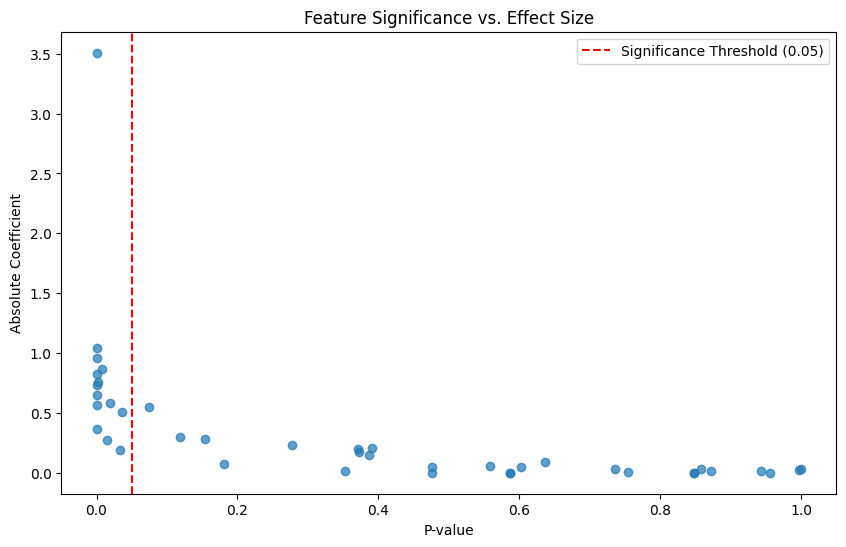

In [26]:
plot_feature_significance(results_df)

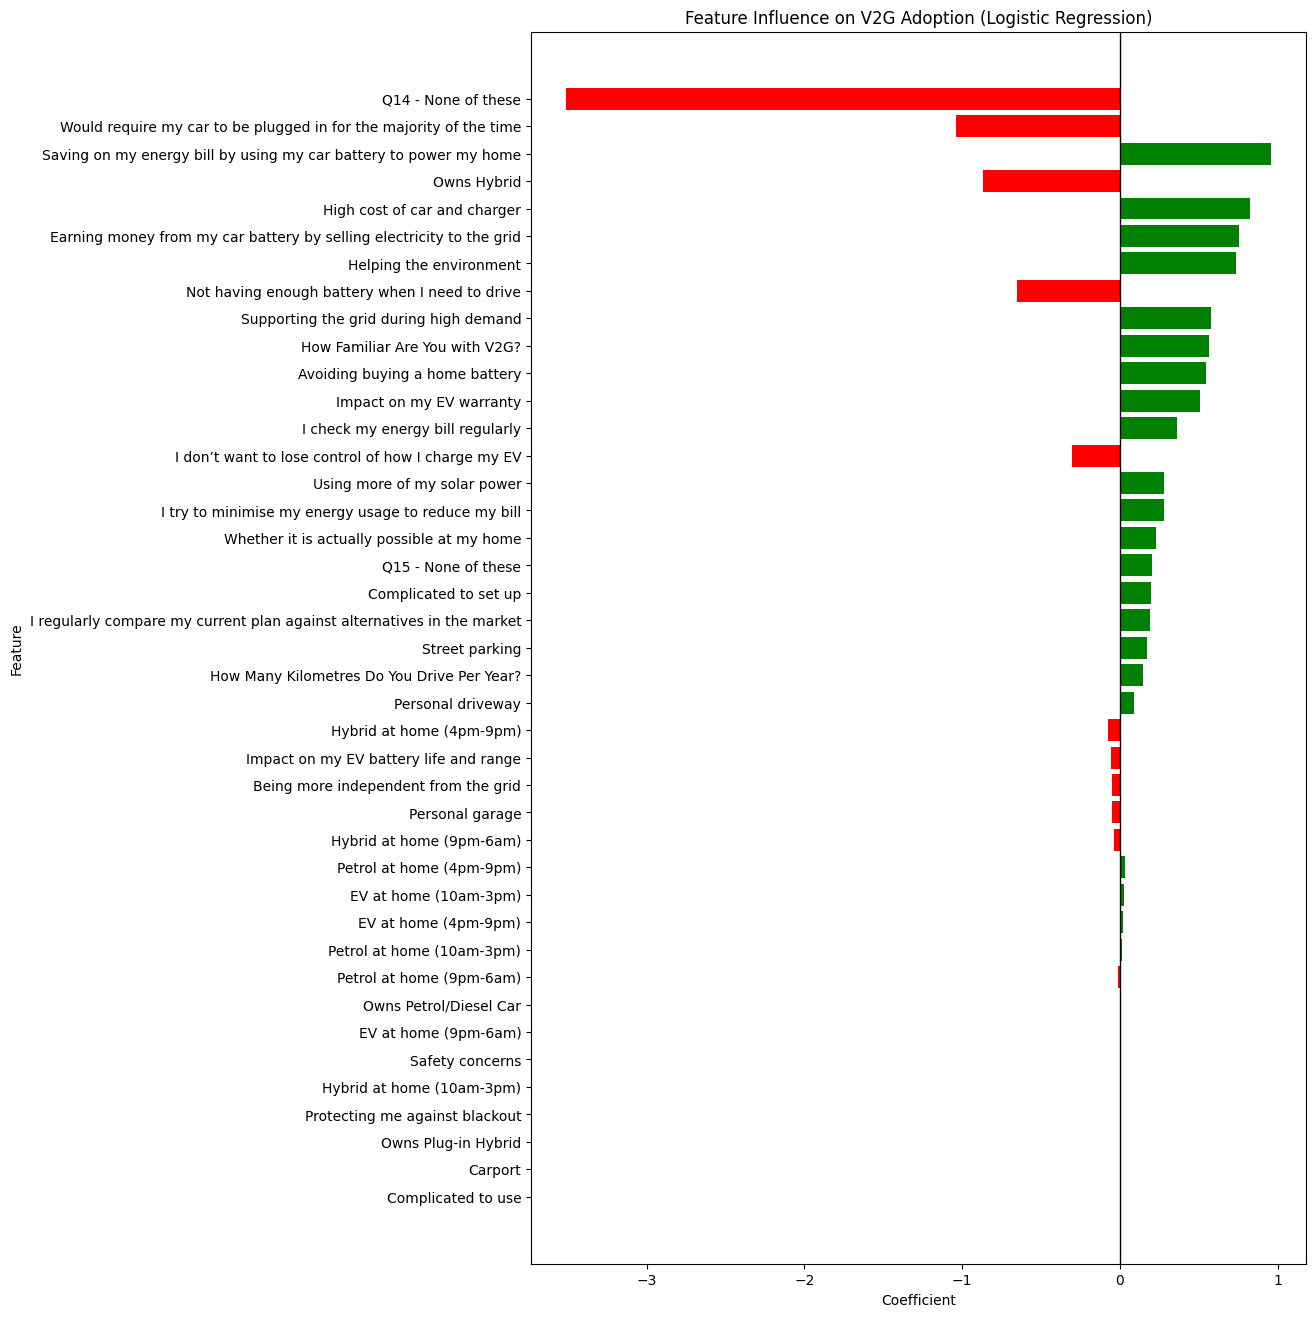

In [27]:
plot_coefficients_barh_by_abscoef(results_df)

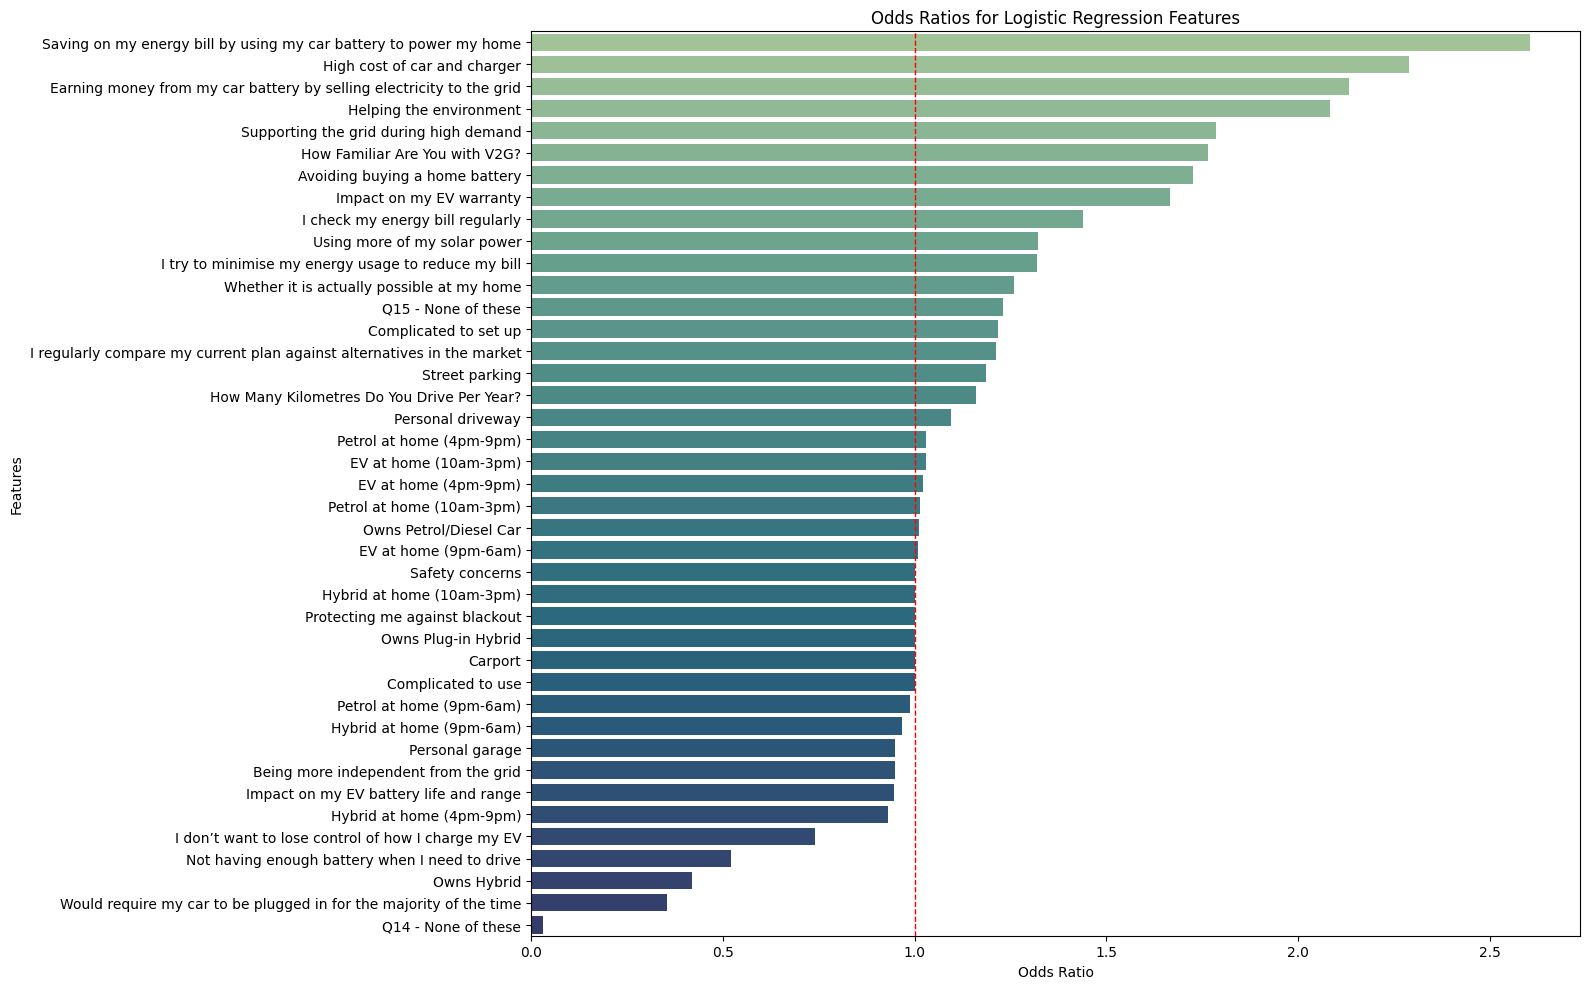

In [28]:
plot_odds_ratio_barh(results_df)

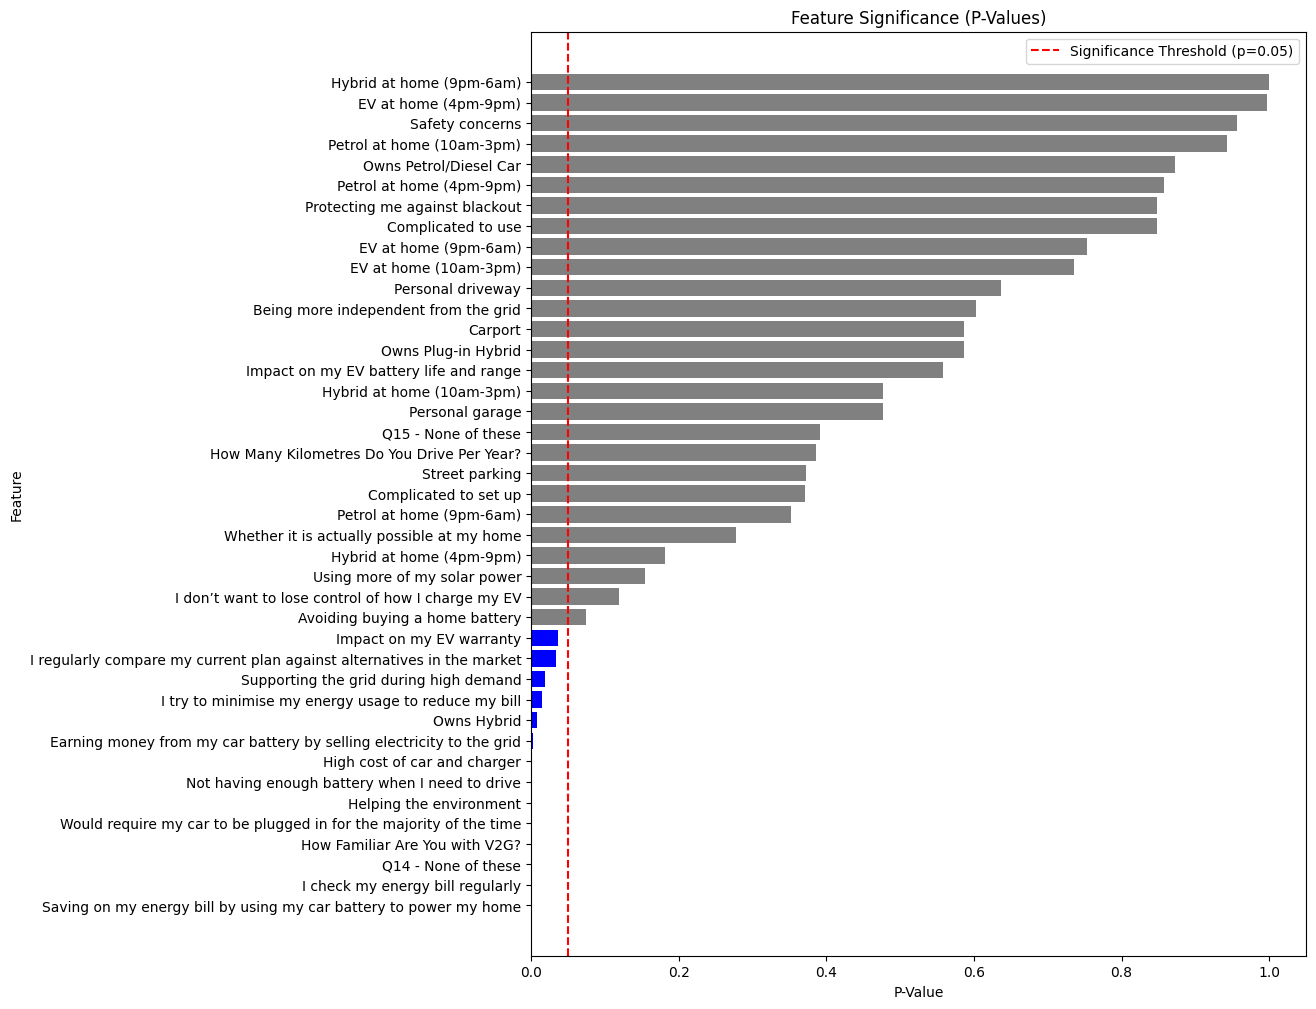

In [29]:
plot_p_value_barh(results_df)

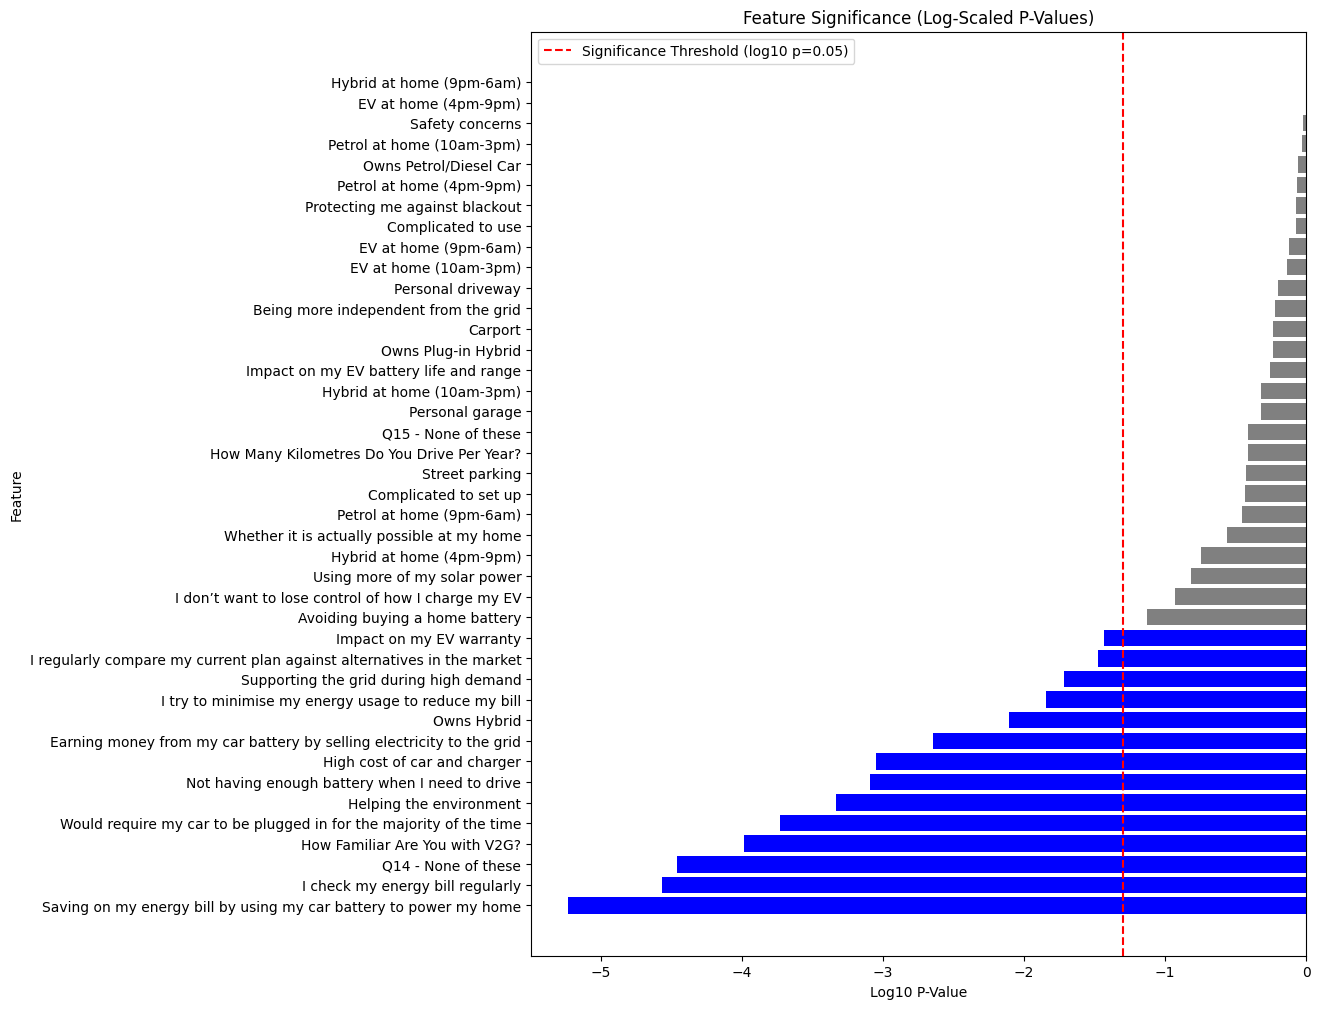

In [30]:
plot_log_p_value_barh(results_df)

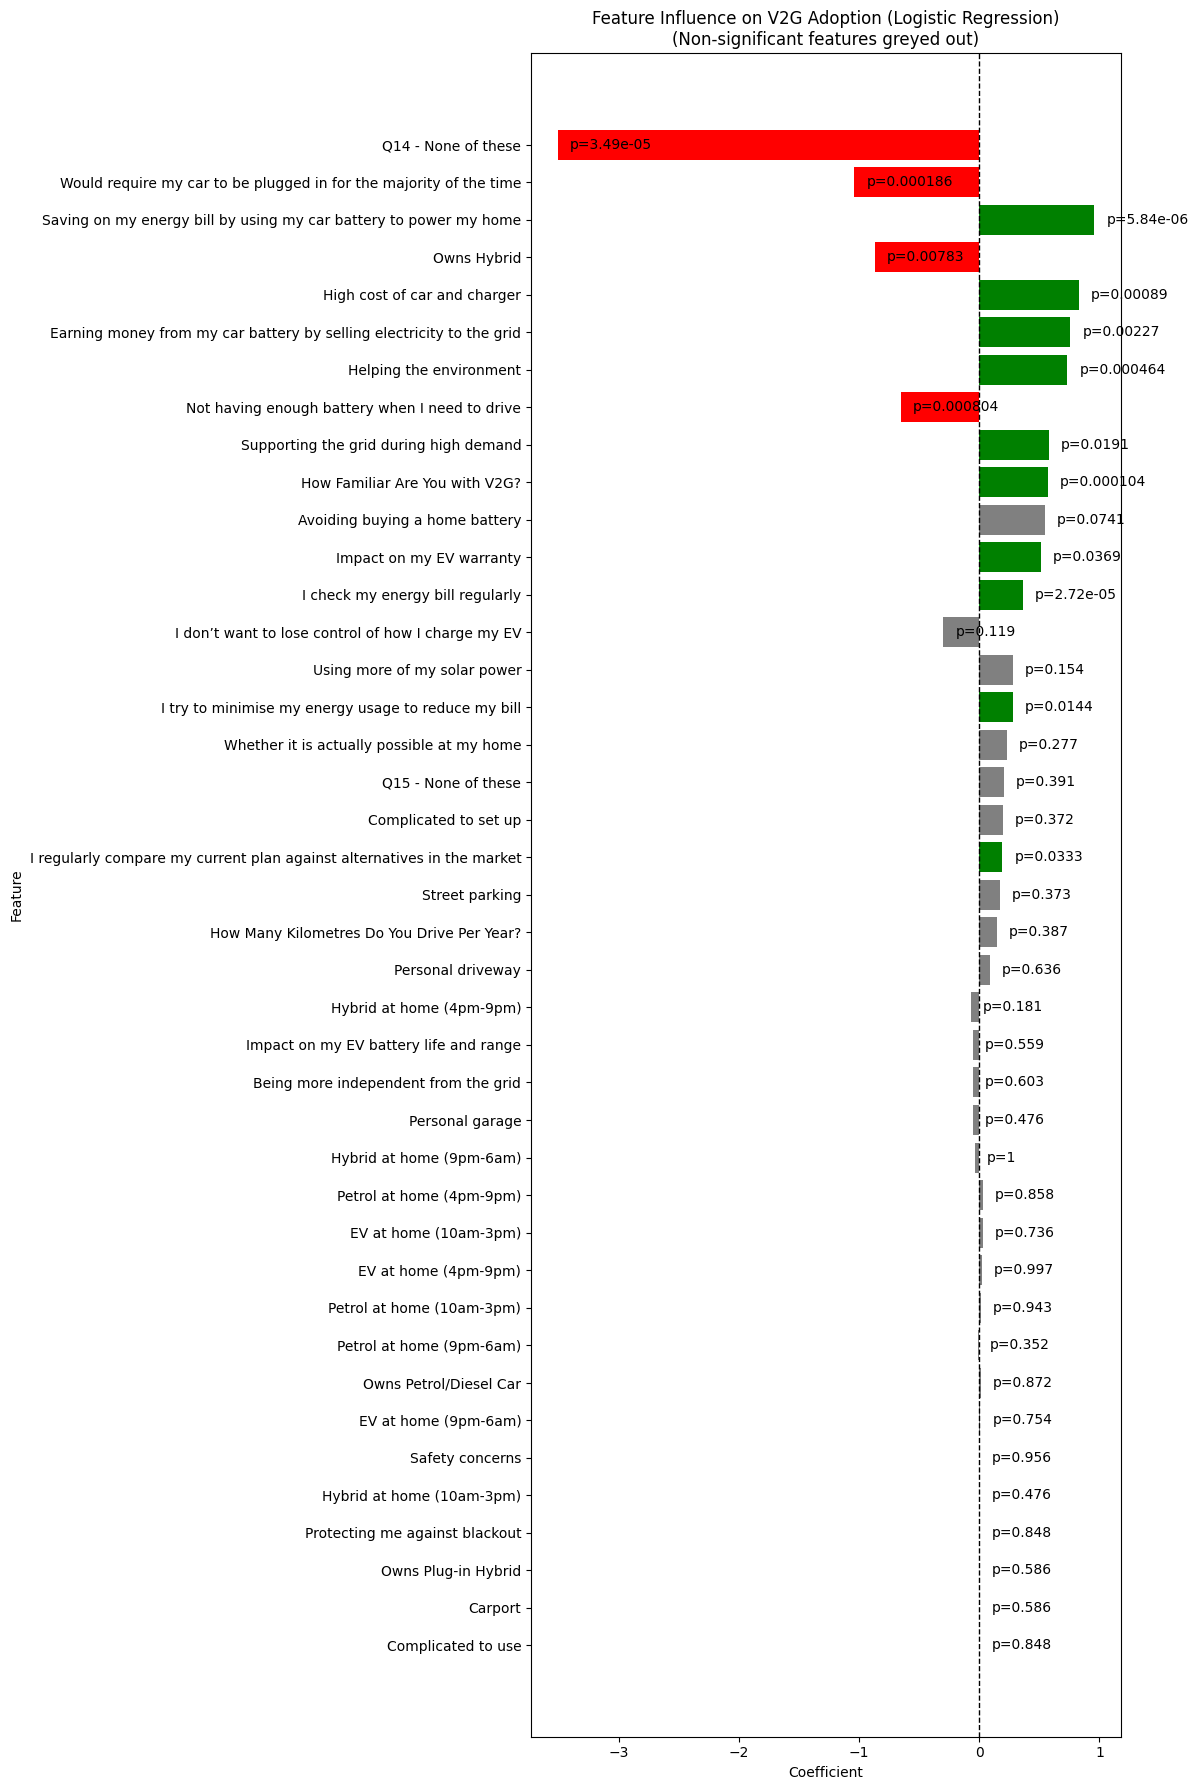

In [31]:
plot_coefficients_significance_barh(results_df)

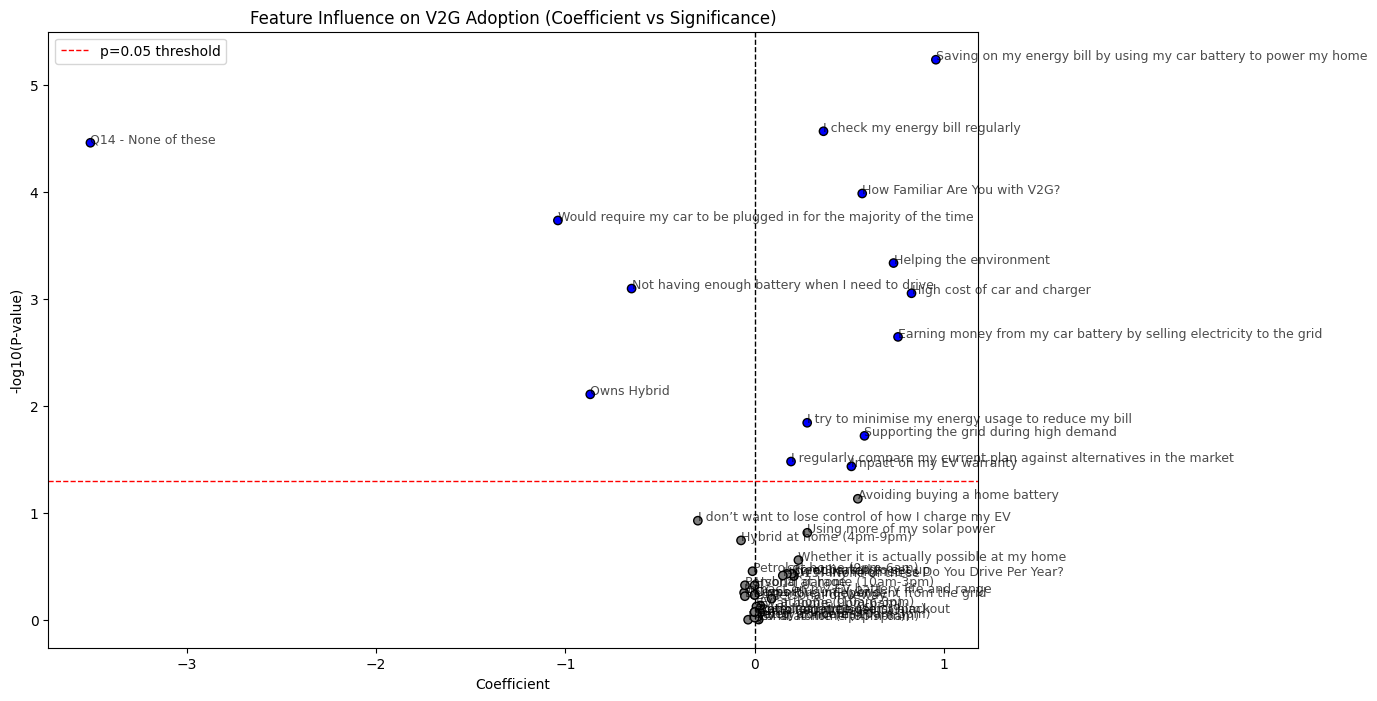

In [32]:
plot_coefficient_vs_significance(results_df)

# 4. Binomial Logistic Regression

## 4.1. Filtering my df based on the previous p-value analysis

In [33]:
columns_of_interest_filtered = filter_significant_features(
    results_df=results_df,
    feature_label_map=feature_label_map,
    columns_of_interest=columns_of_interest,
    target_variable=target_variable
)

Original columns count: 59
Filtered columns count: 15


In [34]:
filtered_df = df[columns_of_interest_filtered]
filtered_df

,Q9,Q1_4,Q14_1,Q14_2,Q14_3,Q14_5,Q14_99,Q15_1,Q15_6,Q15_7,Q15_9,Q7_1,Q7_2,Q7_3,Q10_2
1,Very familiar,0,0,0,1,0,0,0,0,0,0,Strongly agree,Strongly agree,Somewhat agree,1
4,Very familiar,1,1,0,0,1,0,1,0,1,0,Strongly agree,Strongly agree,Somewhat agree,1
5,Very familiar,0,0,1,0,0,0,1,0,0,0,Strongly agree,Strongly agree,Somewhat agree,1
10,Somewhat familiar,0,1,0,0,0,0,0,1,1,0,Strongly agree,Strongly agree,Somewhat agree,0
11,Very familiar,0,1,0,0,1,0,0,1,0,0,Somewhat agree,Somewhat agree,Somewhat agree,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,Somewhat familiar,0,0,0,1,1,0,0,0,1,0,Strongly agree,Somewhat agree,Somewhat disagree,1
1352,Very familiar,0,0,0,1,0,0,0,0,1,0,Strongly agree,Strongly agree,Somewhat agree,1
1353,Somewhat familiar,0,0,1,1,0,0,0,1,1,0,Strongly agree,Strongly agree,Neither agree nor disagree,1
1355,Very familiar,0,1,0,0,1,0,0,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,1


## 4.2. Running regression

In [35]:
filtered_df['Q6ax1_1'] = filtered_df['Q6ax1_1'].fillna(0)
filtered_df['Q6ax3_2'] = filtered_df['Q6ax3_2'].fillna(0)

KeyError: 'Q6ax1_1'

In [36]:
print("Checking if any feature column is missing data...")
print(filtered_df.isnull().sum())

print("\nChecking unique values in target variable (Q10_2):")
print(filtered_df[target_variable].unique())

print("\nChecking number of non-missing rows in dataset:")
valid_rows = filtered_df.dropna().shape[0]
print(f"Valid rows: {valid_rows} / {df.shape[0]}")


Checking if any feature column is missing data...
Q9        0
Q1_4      0
Q14_1     0
Q14_2     0
Q14_3     0
Q14_5     0
Q14_99    0
Q15_1     0
Q15_6     0
Q15_7     0
Q15_9     0
Q7_1      0
Q7_2      0
Q7_3      0
Q10_2     0
dtype: int64

Checking unique values in target variable (Q10_2):
[1 0]

Checking number of non-missing rows in dataset:
Valid rows: 557 / 557


In [37]:
# Let's confirm all columns in columns_of_interest_filtered have a transformer
for col in columns_of_interest_filtered:
    transformer_func = TRANSFORMERS_q6a.get(col, fallback_text_to_float)
    print(f"Column {col}: transformer = {transformer_func.__name__ if transformer_func else 'None'}")

Column Q9: transformer = text_to_code_q9
Column Q1_4: transformer = text_to_code_binary
Column Q14_1: transformer = text_to_code_binary
Column Q14_2: transformer = text_to_code_binary
Column Q14_3: transformer = text_to_code_binary
Column Q14_5: transformer = text_to_code_binary
Column Q14_99: transformer = text_to_code_binary
Column Q15_1: transformer = text_to_code_binary
Column Q15_6: transformer = text_to_code_binary
Column Q15_7: transformer = text_to_code_binary
Column Q15_9: transformer = text_to_code_binary
Column Q7_1: transformer = text_to_code_q7_likert
Column Q7_2: transformer = text_to_code_q7_likert
Column Q7_3: transformer = text_to_code_q7_likert
Column Q10_2: transformer = text_to_code_q10_2_binary


In [38]:
model_binary, X_train, y_train, X_test, y_test = build_v2g_model_binary_from_df(
    filtered_df,  
    columns_of_interest_filtered,
    target_variable,  
    TRANSFORMERS_q6a,  
    do_normalize=True,
    test_split_ratio=0.2
)

Unique values in y_train: (array([0, 1]), array([ 93, 352], dtype=int64))
Unique values in y_test: (array([0, 1]), array([20, 92], dtype=int64))
Train Accuracy: 82.02%
Test Accuracy: 87.50%


# 5. Visualisation of results

## 5.1. Coefficients

In [39]:
# Extract coefficients
coefs_binary = model_binary.coef_[0]  # Shape: (1, n_features), so take [0]

# Create DataFrame for visualization
coefs_binary_df = pd.DataFrame({'Feature': columns_of_interest_filtered, 'Coefficient': coefs_binary})
coefs_binary_df.sort_values(by="Coefficient", ascending=False, inplace=True)
coefs_binary_df["Feature"] = coefs_binary_df["Feature"].map(feature_label_map)

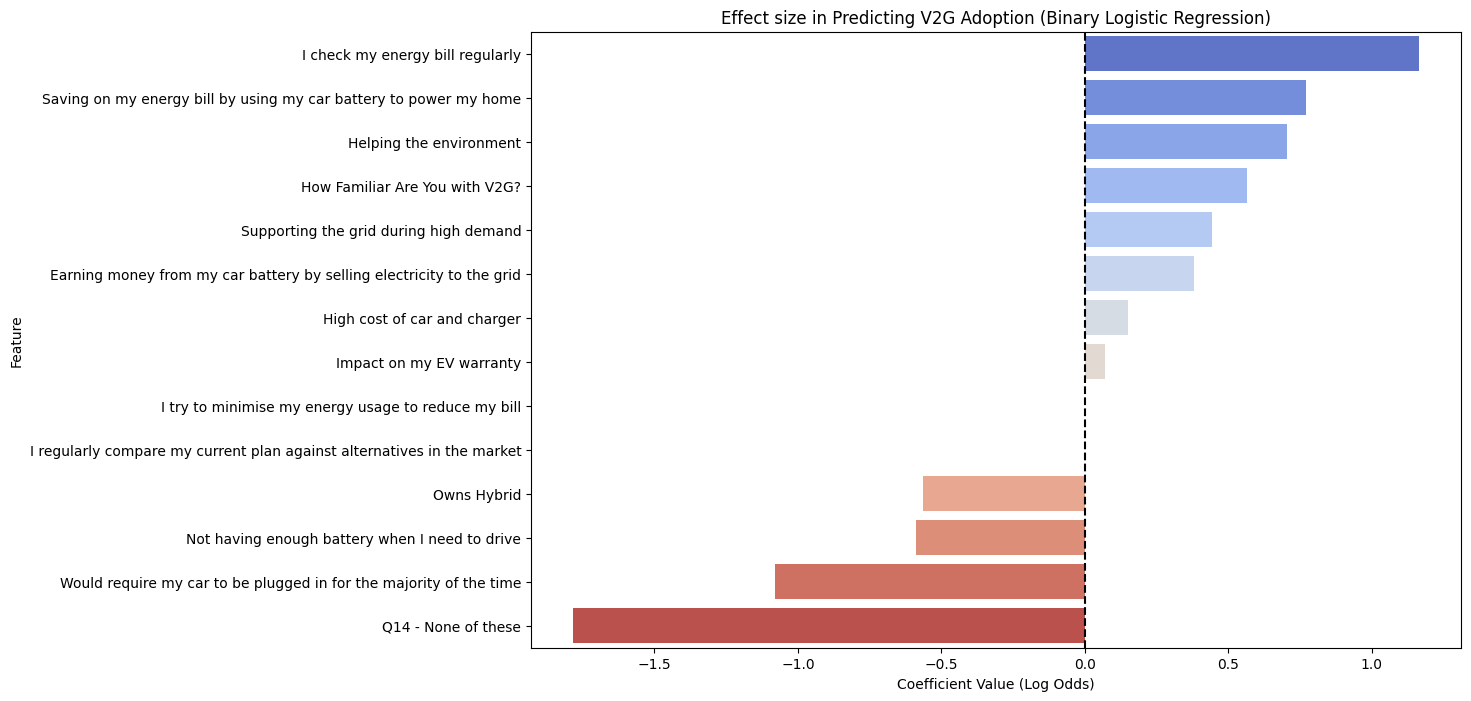

In [40]:
plot_coefficients_barplot(coefs_binary_df)

## 5.2. Odds Ratio

In [41]:
coefs_binary_df["Odds Ratio"] = np.exp(coefs_binary_df["Coefficient"])
coefs_binary_df.sort_values(by="Odds Ratio", ascending=False, inplace=True)

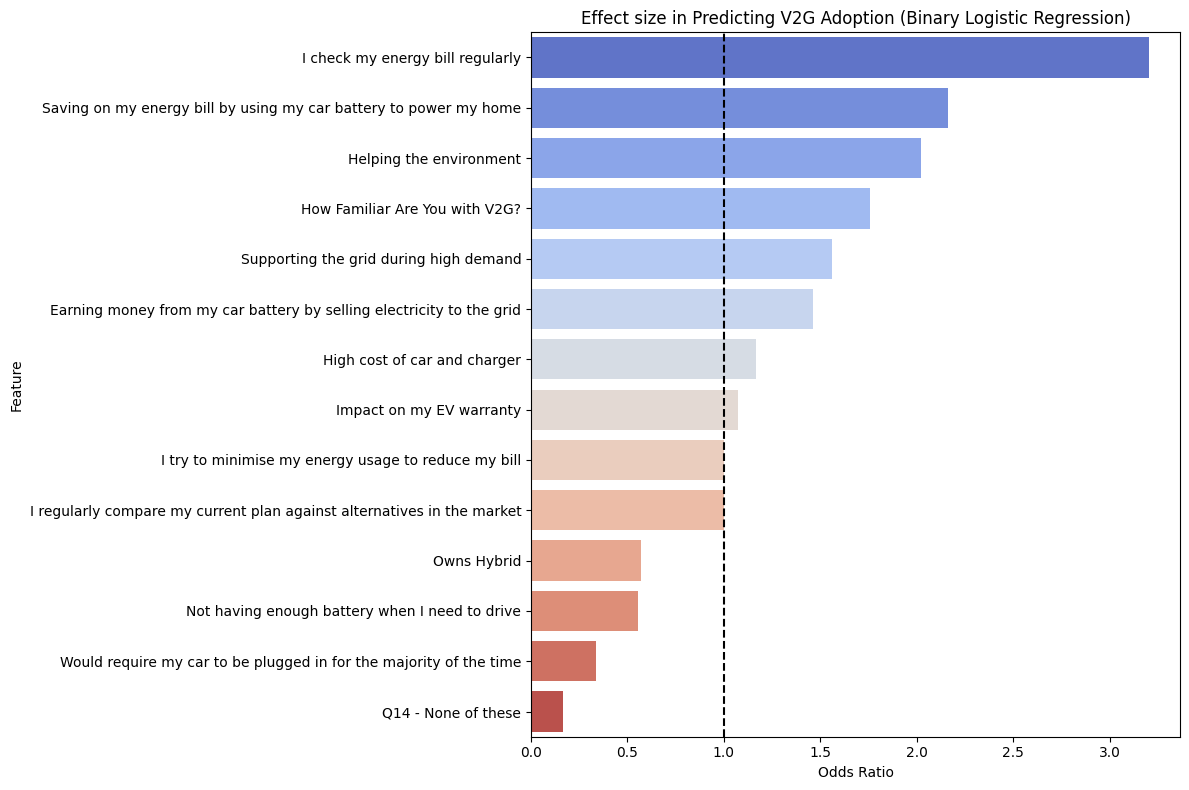

In [42]:
plot_odds_ratios_barplot(coefs_binary_df)

In [43]:
# Sort features by absolute coefficient magnitude for better visualization
coefs_binary_df["abs_coef"] = coefs_binary_df["Coefficient"].abs()
coefs_binary_df = coefs_binary_df.sort_values(by="abs_coef", ascending=False)

In [ ]:
plot_coefficients_by_abs(coefs_binary_df)

In [ ]:
# Predict on test data
y_pred_binary = model_binary.predict(X_test)
# Compute accuracy
accuracy_binary = accuracy_score(y_test, y_pred_binary)
print(f"Model Accuracy: {accuracy_binary:.2%}")

In [ ]:
plot_binary_confusion_matrix(y_test, y_pred_binary, labels=["Not Adopting", "Adopting"])

# 6. Correlation matrix

In [ ]:
corr_mat = transform_and_plot_correlation(
    filtered_df, 
    TRANSFORMERS,
    figsize=(20, 16),
    title="Correlation Matrix of Transformed Features"
)